In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
Image_size = 256
Batch_size = 32
CHANNELS=3
EPOCHS=50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size=(Image_size, Image_size),
    batch_size=Batch_size
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

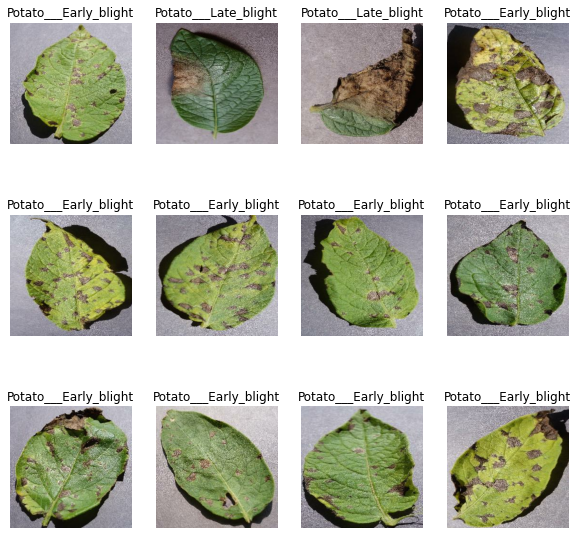

In [7]:
plt.figure(figsize=(10,10))
# we visualize the data
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
# train test validation set seperation
train_size = 0.8
len(dataset)* train_size

54.400000000000006

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [11]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [14]:
def get_datasets_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(train_split* ds_size)
    val_size = int(val_split* ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    
    return train_ds, test_ds, val_ds

In [15]:
train_ds, test_ds, val_ds = get_datasets_partitions_tf(dataset)

In [16]:
len(train_ds)

54

In [17]:
len(test_ds)

8

In [18]:
#Cache, Shuffle, Prefetch the data
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [19]:
# Here data Augmentation Needed Data rescaling, Data resizing is imp (so in future aspects the data will be sorted)
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_size,Image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [20]:
# Data Augmentation to make our model robust
# watch vedio TensorFlow data augmentation codebasics

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),

])

In [21]:
# Apply data augmentation on training set:
train_ds = train_ds.map(
    lambda x,y : (data_augmentation(x,training = True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
input_shape = (Batch_size, Image_size, Image_size, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

In [24]:
model.compile(
    optimizer ='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [29]:
history = model.fit(
    train_ds,
    batch_size= Batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 86s 2s/step - loss: 0.0179 - accuracy: 0.9942 - val_loss: 0.0448 - val_accuracy: 0.9844
Epoch 2/50
54/54 [==============================] - 92s 2s/step - loss: 0.0350 - accuracy: 0.9832 - val_loss: 0.0407 - val_accuracy: 0.9844
Epoch 3/50
54/54 [==============================] - 89s 2s/step - loss: 0.0189 - accuracy: 0.9954 - val_loss: 0.0497 - val_accuracy: 0.9844
Epoch 4/50
54/54 [==============================] - 91s 2s/step - loss: 0.0411 - accuracy: 0.9832 - val_loss: 0.2472 - val_accuracy: 0.9167
Epoch 5/50
54/54 [==============================] - 86s 2s/step - loss: 0.0166 - accuracy: 0.9942 - val_loss: 0.0676 - val_accuracy: 0.9896
Epoch 6/50
54/54 [==============================] - 88s 2s/step - loss: 0.0142 - accuracy: 0.9948 - val_loss: 0.0646 - val_accuracy: 0.9740
Epoch 7/50
54/54 [==============================] - 89s 2s/step - loss: 0.0511 - accuracy: 0.9809 - val_loss: 0.0378 - val_accuracy: 0.9896
Epoch 8/50
54/54 [==

KeyboardInterrupt: 

In [30]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 324ms/step - loss: 0.2172 - accuracy: 0.9414


In [31]:
scores

[0.21720005571842194, 0.94140625]

## Plotting the Accuracy and Loss Curves

In [28]:
history